# subset OVEN song detections to date/time/points with full coverage, and extract clips to dataset
this notebook subsets all 2021-2024 Ovenbird detections, selects a date and time range May 15-26 6-7:30 that has full coverage for 126 points for all years, and extracts audio clips of each songs detected with 'strict' Hawkears detections into a consolidated dataset of mp3 files.

The clips are summarized in pam_dataset_v4/pam_dataset_clips.csv.

> Note: the inputs to this script are not included in this repository. The script is included for reference only. The dataset created by this script is a public dataset of Ovenbird detections in the selected date and time window. That dataset can be downloaded and used to reproduce downstream analyses and results. 

In [ ]:
from opensoundscape import Audio, Spectrogram, CNN, BoxedAnnotations

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import numpy as np
np.random.seed(2024)
import datetime

In [ ]:
metadata = {
    # REDACTED
}

datasets = {
    # REDACTED
}

In [ ]:
points = pd.read_csv("../../resources/point_list_with_utm.csv").set_index(
    "point_code", drop=True
)

start_date = datetime.date(1000, 5, 15)
end_date = datetime.date(1000, 5, 26)
dataset_dir = "../../../pam_dataset_v4/"
points_list = list(points.index)

In [ ]:
dpls = {}
all_dets = []
center_dets = glob("REDACTED")


for det_path in center_dets:
    deployment = Path(det_path).stem.split("_")[-1]
    print(f"deployment: {deployment}")

    dets = pd.read_csv(det_path)
    print(f"loaded {len(dets)} dets for {deployment}")
    dets["card"] = dets["file"].apply(lambda x: x.split("/")[-2])
    dataset = deployment

    if not dataset in metadata:
        print(f"skipping {dataset} - no metadata")
        continue
    dpl = pd.read_csv(metadata[dataset])
    dpl = dpl.set_index("card_code")
    if "dropoff:Point ID" in dpl.columns:
        dpl = dpl.rename(columns={"dropoff:Point ID": "point_code"})

    dets["dataset"] = dataset
    dets["card"] = dets["file"].apply(lambda x: x.split("/")[-2])

    # discard detections for cards without metadata
    dets = dets[dets.card.apply(lambda x: x in dpl.index)]

    # discard points not listed in master data entry
    dets["point_code"] = dets["card"].apply(lambda x: dpl.at[x, "point_code"])
    dets = dets.dropna(subset=["point_code"])

    dets["site"] = dets["point_code"].apply(
        lambda x: points.at[x, "site_name"] if x in points.index else np.nan
    )

    # remove points not in SGL 34 or Ohiopyle
    dets = dets[[d == d and d in ["SGL034", "Ohiopyle"] for d in dets.site]]

    # filter to points included in our study (have data for all dates and years)
    dets = dets[dets["point_code"].isin(points_list)]

    # filter to dates and times
    dets["datetime"] = dets["file"].apply(audiomoth_start_time)
    dets["date"] = dets["datetime"].apply(lambda x: x.date())
    dets["time"] = dets["datetime"].apply(lambda x: x.time())
    dets["date_no_year"] = dets["date"].apply(lambda x: x.replace(year=1000))
    dets["year"] = dets["dataset"].apply(lambda x: x[-5:-1]).astype(int)
    dets["local_time_hrs"] = dets.apply(
        lambda x: (x["time"].hour - 4)
        + (x["time"].minute) / 60
        + x["start_time"] / 60 / 60,
        axis=1,
    )
    dets = dets[(dets.date_no_year <= end_date) & (dets.date_no_year >= start_date)]
    dets = dets[(dets["local_time_hrs"] >= 6) & (dets["local_time_hrs"] <= 7.5)]

    # store deployment sheet for future reference
    dpls[dataset] = dpl

    # add utm coordinates
    dets["utm_E"] = dets["point_code"].apply(lambda x: points.at[x, "utm_E"])
    dets["utm_N"] = dets["point_code"].apply(lambda x: points.at[x, "utm_N"])

    print(f"{dataset}: {len(dets)}")
    dets.to_csv(f"REDACTED/{dataset}.csv")

deployment: earl2022b
loaded 270456 dets for earl2022b
earl2022b: 53164
deployment: appl2021e
loaded 344521 dets for appl2021e
appl2021e: 32454
deployment: earl2023b
loaded 197204 dets for earl2023b
earl2023b: 42831
deployment: earl2024a
loaded 201840 dets for earl2024a
earl2024a: 37515


In [ ]:
all_dets = pd.concat(
    [
        pd.read_csv(
            f"REDACTED/{dataset}.csv",
            index_col=0,
            parse_dates=["date", "time", "datetime", "date_no_year"],
        )
        for dataset in ["appl2021e", "earl2022b", "earl2023b", "earl2024a"]
    ]
)

/tmp/ipykernel_807292/4172335308.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(
/tmp/ipykernel_807292/4172335308.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(
/tmp/ipykernel_807292/4172335308.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(
/tmp/ipykernel_807292/4172335308.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(


In [19]:
all_dets.date_no_year = all_dets.date.apply(
    lambda d: pd.Timestamp(d).to_pydatetime().replace(year=1000)
)

/tmp/ipykernel_807292/2554915995.py:3: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.histplot(


<Axes: xlabel='date_no_year', ylabel='Count'>

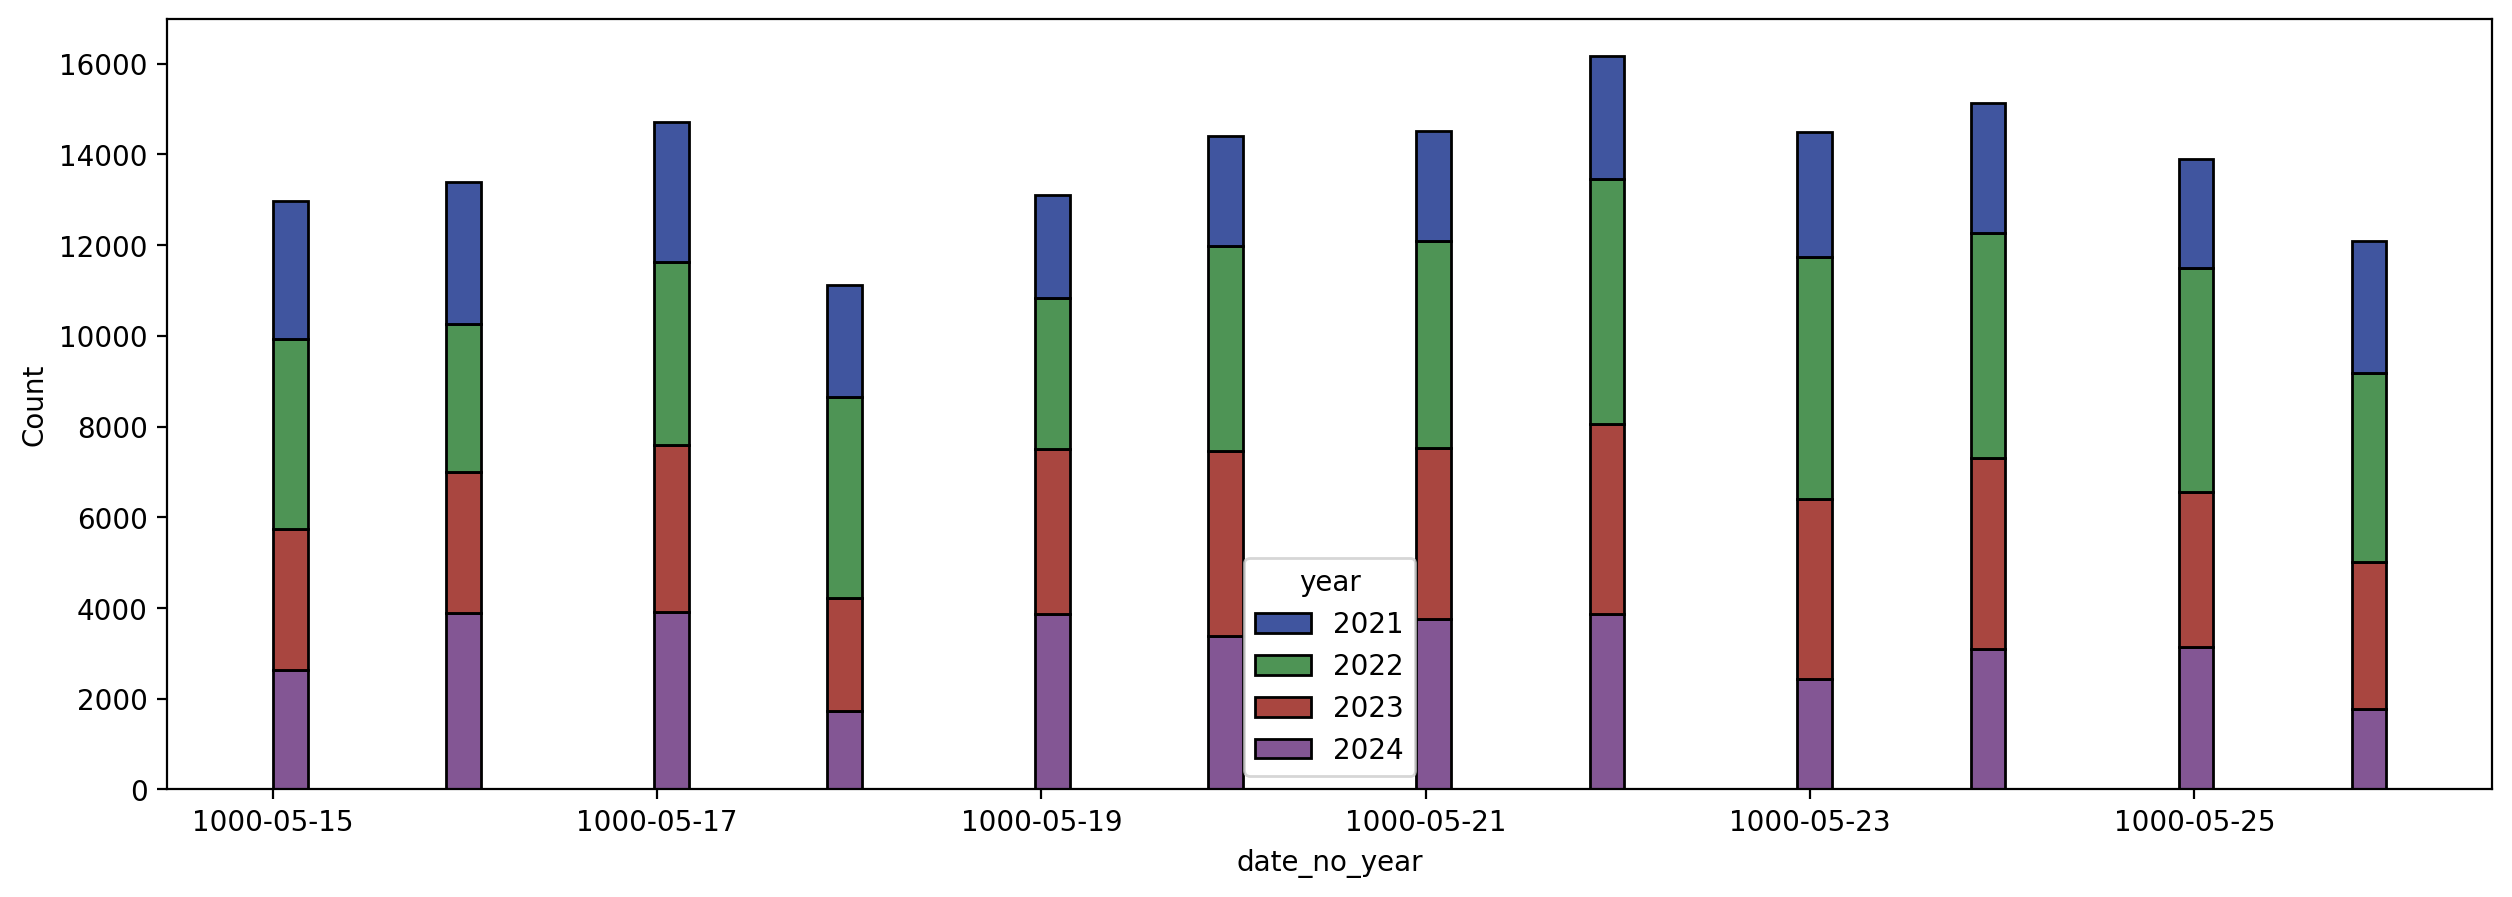

In [20]:
import seaborn as sns

sns.histplot(
    all_dets,
    x="date_no_year",
    hue="year",
    palette=sns.color_palette("dark6"),
    multiple="stack",
)

/tmp/ipykernel_807292/1682926678.py:3: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.histplot(


<Axes: xlabel='local_time_hrs', ylabel='Count'>

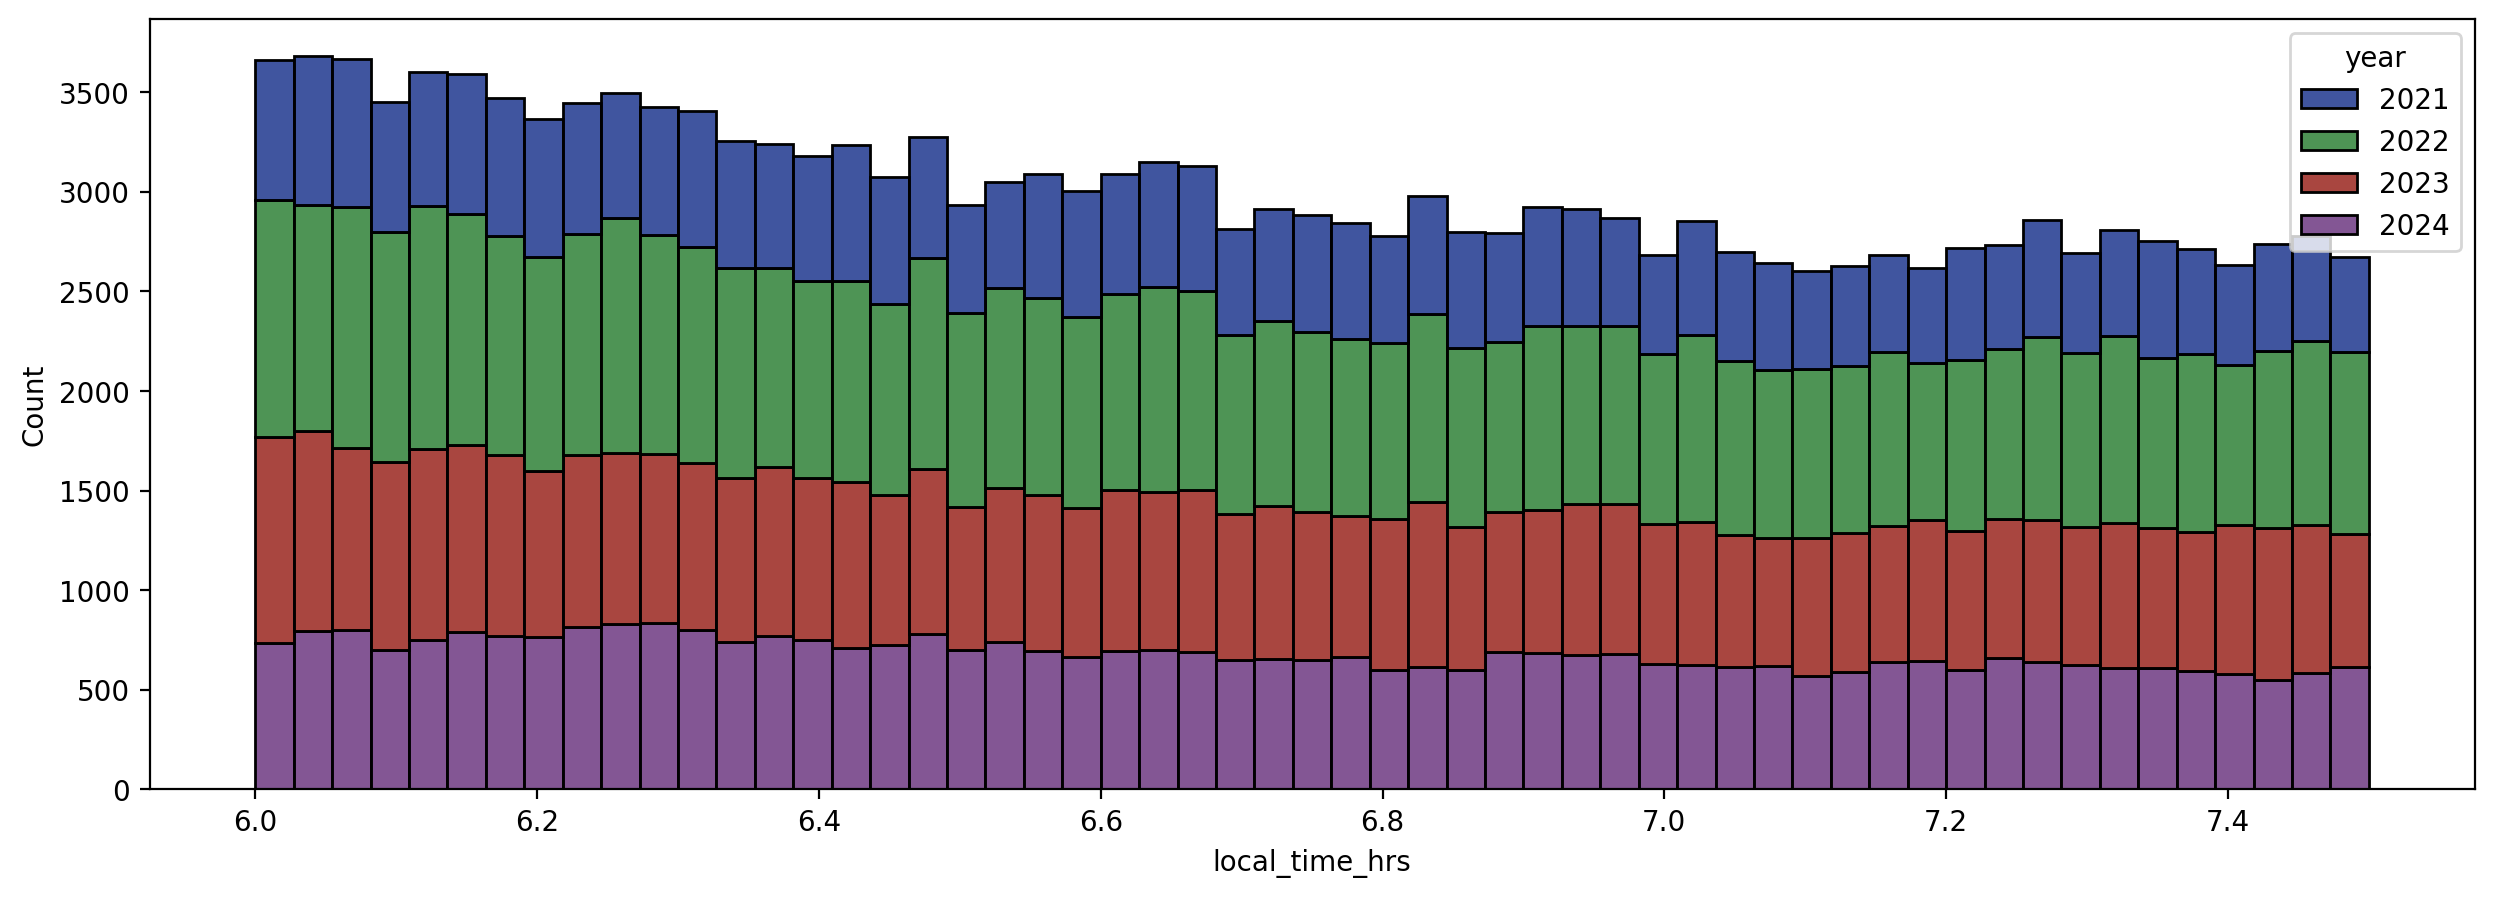

In [21]:
import seaborn as sns

sns.histplot(
    all_dets,
    x="local_time_hrs",
    hue="year",
    palette=sns.color_palette("dark6"),
    multiple="stack",
)

In [22]:
import datetime

all_dets.groupby("year")[
    "point_code"
].nunique()  # not all sites will have detections every year

year
2021    119
2022    117
2023    114
2024    117
Name: point_code, dtype: int64

In [24]:
all_dets.groupby("year")["date"].nunique()

year
2021    12
2022    12
2023    12
2024    12
Name: date, dtype: int64

In [25]:
all_dets.groupby("year")["local_time_hrs"].max(), all_dets.groupby("year")[
    "local_time_hrs"
].min()

(year
 2021    7.500000
 2022    7.500000
 2023    7.500000
 2024    7.499167
 Name: local_time_hrs, dtype: float64,
 year
 2021    6.0
 2022    6.0
 2023    6.0
 2024    6.0
 Name: local_time_hrs, dtype: float64)

In [26]:
len(all_dets)

165964

In [ ]:
clip_df = all_dets.reset_index()
clip_df["clip_name"] = clip_df.apply(
    lambda row: f"{row.name:07n}_{row.point_code}_{row.year}.mp3", axis=1
)
clip_df["datetime"] = clip_df.apply(
    lambda row: row["datetime"].astimezone("US/Eastern")
    + datetime.timedelta(seconds=row["start_time"]),
    axis=1,
)
clip_df["date"] = clip_df["datetime"].apply(lambda x: x.date())
clip_df["time"] = clip_df["datetime"].apply(lambda x: x.time())
clip_df[
    [
        "file",
        "start_time",
        "clip_name",
        "point_code",
        "site",
        "datetime",
        "date",
        "time",
        "Ovenbird",
    ]
].to_csv(f"{dataset_dir}/pam_dataset_clips.csv", index=False)

In [ ]:
def extract_clip(row):
    clip_path = f"{dataset_dir}/audio/{row.clip_name}"
    if Path(clip_path).exists():
        return
    Audio.from_file(
        row.file, load_metadata=False, offset=row.start_time, duration=3
    ).save(clip_path, compression_level=0.1)

not all sites will have Ovenbird detections on all years - that's ok


In [18]:
dets_per_year = (
    all_dets.groupby(["year", "point_code"]).size().unstack().fillna(0).astype(int)
)
dets_per_year.to_csv("./dets_per_site_and_year.csv")
# dets_per_year
dets_per_year

point_code,RK001,RK004,RK007,RK010,RK016,RK062,RK063,RK065,RK1000,RK1003,...,RK962,RK964,RK966,RK969,RK974,RK976,RK983,RK984,RK986,RK990
year,,,,,,,,,,,,,,,,,,,,,
2021,482,220,18,146,322,436,27,454,1,547,...,39,1031,85,0,20,212,413,52,992,354
2022,611,1445,727,1028,388,595,139,568,12,274,...,26,556,117,0,39,1227,26,16,575,143
2023,1086,290,571,434,364,149,1,221,7,217,...,14,143,157,3,78,179,171,177,313,93
2024,983,182,1154,737,341,658,49,683,13,50,...,165,48,149,0,73,268,321,3,265,359


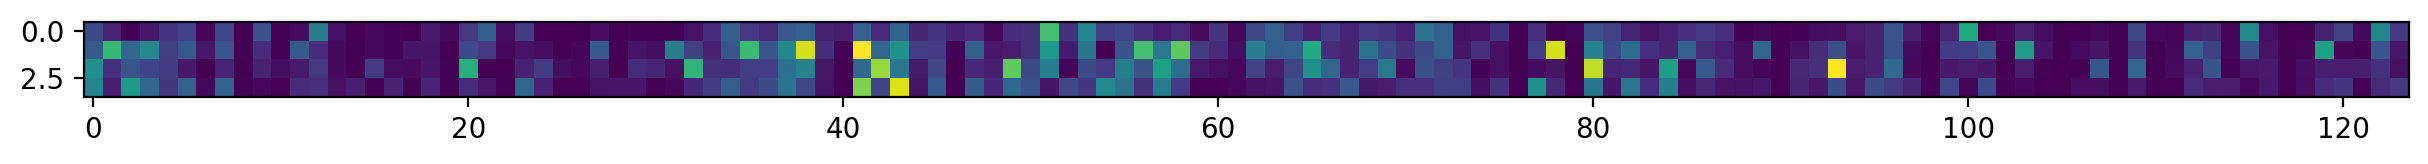

In [19]:
plt.imshow(dets_per_year.values)

#### prepare metadata of point codes with covariates
RK008 does not have vegetation / habitat data, so I excluded it from the included points

In [ ]:
point_metadata = pd.read_csv(
    "REDACTED",
    index_col="point_code",
)
point_metadata.loc["RK008"] = np.nan
point_locations = pd.read_csv(
    "REDACTED",
    index_col="point_code",
)
point_metadata = (
    point_metadata.loc[points_list]
    .join(point_locations.drop(columns="Notes"))
    .rename(columns={"Block": "site"})
)
point_metadata.drop(
    columns=[
        "point_description",
        "X",
        "Y",
        "elev",
        "ortho_ht",
        "UTM Zone",
        "UTM Easting",
        "UTM Northing",
        "site_name",
        "deployable",
        "deployment_issue",
        "difficulty_rating",
        "updated_by",
        "update_datetime",
        "Region",
        "Transect",
        "Transect meters",
    ],
    inplace=True,
)
point_metadata["utm_zone"] = point_metadata["utm_zone"].astype(int)
point_metadata["utm_N"] = point_metadata["utm_N"].round().astype(int)
point_metadata["utm_E"] = point_metadata["utm_E"].round().astype(int)

# remove survyes from 2020 that were repeated in 2021
# this is generally because there was management in 2020, and 2021 has updated veg survey
point_metadata = point_metadata.sort_values(by="Year", ascending=True)
point_metadata = point_metadata[~point_metadata.index.duplicated(keep="last")]
assert set(point_metadata.index) == set(points_list)
point_metadata.to_csv(f"{dataset_dir}/habitat_measures_at_points.csv")